<a href="https://colab.research.google.com/github/Amandaagambire/Galamsey-Watch/blob/main/Copy_of_Jessie's_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import math
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import copy
import random

we're looking at some sort of generator that changes so a distribution that shifts to a different distribution at some point in time and we can write generators that will simulate this problem

base generator object lays out our interface, perform some sort of setup in the initialization:


In [ ]:
class Generator(object):
  def __init__(self):
    self.changepoint = -1

  def get(self):
    self.changepoint += 1
    return 1.0

get method should return the next data point in the sequence

In [ ]:
class DistributionGenerator (Generator):
    """
    A generator which generates values from a single distribution. This may not immediately
    appear useful for change detection, however if we can model our unchanged data stream
    as a distribution then we can test against false positives by running tests against
    a single distribution.

    dist1:  A scipy.stats distribution for before changepoint.
    kwargs: The keyword arguments are passed to the distribution.
    """

    def __init__(self, dist, **kwargs):
      self._dist = dist
      self._args = kwargs

    def get(self):
      return self._dist.rvs(**self._args)

DistributionGenerator function takes a sci-fi distribution and it's keyword arguments and returns a random variate from it during each call to get

Why is a single distribution generator useful when performing change detection? This is good for determining when algorithm might generate a false positive.
If your entire generator is drawing on a single distribution that we know it doesn't change so you can run your detection algorithms against that and determine it would have produced a false positive

In [ ]:
class ChangingDistributionGenerator(Generator):
    """
    A generator which takes two distinct distributions and a changepoint and returns
    random variates from the first distribution until it has reached the changepoint
    when it then switches to the next.

    dist1:       A scipy.stats distribution for before changepoint.
    kwargs1:     A map specifying loc and scale for dist1.
    dist2:       A scipy.stats distribution for after changepoint.
    kwargs2:     A map specifying loc and scale for dist2.
    changepoint: The number of values to be generated before switching to dist2.
    """
    _position = 0

    def __init__(self, dist1, kwargs1, dist2, kwargs2, changepoint):
      self._dist1 = dist1
      self._kwargs1 = kwargs1
      self._dist2 = dist2
      self._kwargs2 = kwargs2
      self._changepoint = changepoint

    def get(self):
      self._position += 1
      if self._position <= self._changepoint:
        return self._dist1.rvs(**self._kwargs1)
      else:
        return self._dist2.rvs(**self._kwargs2)

ChangingDistributionGenerator is basically the same concept as DistributionGenerator except for you provide two distributions, two sets of keyword arguments and a changepoint and before a changepoint will sample the first distribution and after the changepoint will sample the second distribution

In [ ]:
class DriftGenerator(Generator):
    """
    A generator which takes two distinct distributions and a changepoint and returns
    random variates from the first distribution until it has reached the changepoint
    when it then drifts to the next.

    dist1:       A scipy.stats distribution for before changepoint.
    kwargs1:     A map specifying loc and scale for dist1.
    dist2:       A scipy.stats distribution for after changepoint.
    kwargs2:     A map specifying loc and scale for dist2.
    changepoint: The number of values to be generated before switching to dist2.
    steps:       The number of time steps to spend drifting to dist2.
    """
    _position = 0

    def __init__(self, dist1, kwargs1, dist2, kwargs2, changepoint, steps):
        self._dist1 = dist1
        self._kwargs1 = kwargs1
        self._dist2 = dist2
        self._kwargs2 = kwargs2
        self._changepoint = changepoint
        self._steps = steps

        self._change_gradient = np.linspace(0, 1, self._steps)

    def get(self):
        self._position += 1
        if self._position < self._changepoint:
            return self._dist1.rvs(**self._kwargs1)
        if self._position >= self._changepoint and self._position < self._changepoint + self._steps:
            beta = self._change_gradient[self._position - self._changepoint]
            return ((1 - beta) * self._dist1.rvs(**self._kwargs1)) + (beta * self._dist2.rvs(**self._kwargs2))
        else:
            return self._dist2.rvs(**self._kwargs2)

Similar to ChangingDistributionGenerator but not abrupt.

self._change_gradient = np.linspace(0, 1, self._steps) : take a linear space between 0 and 1 over the number of steps we need and we're just going to use create a mixture there

Data Examples:

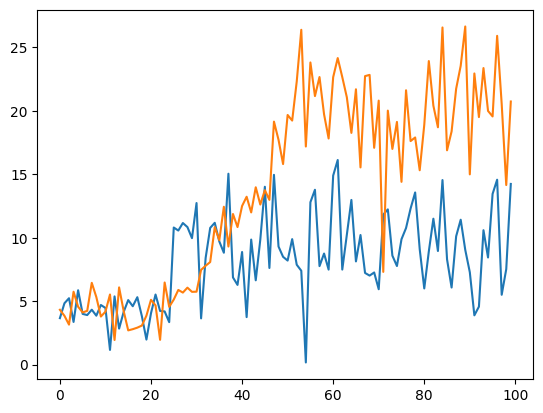

In [ ]:
gen = ChangingDistributionGenerator(stats.norm, {'loc': 4, 'scale': 1}, stats.norm, {'loc': 10, 'scale': 3}, 25)

vals = np.zeros(100)
for i in range(100):
  vals[i] = gen.get()

plt.plot(vals)

gen = DriftGenerator(stats.norm, {'loc': 4, 'scale': 1}, stats.norm, {'loc': 20, 'scale': 3}, 25, 30)

vals = np.zeros(100)
for i in range(100):
  vals[i] = gen.get()

plt.plot(vals)

Loss Functions:
The higher the value the worse that the algorithm did

Our simulator will be designed to take these loss functions and apply them to the results of the simulation so that we can see if one technique is better than the other


Change Detector record changepoint and then have a step function that ingests each piece of data decides what to do with it and then returns whether or not we've triggered our detection

If we detect a change we set triggered to true and we return that

This base one her simply just checks to see if the same value if the the value that just came in was the exact same as the last one; never useful, this is a degenerate case of the problem but you will know when something was not supposed to be all zeros and then suddenly you've got a value.

For example, if you were monitoring a perfectly quiet room with a microphone or something but even then you're probably getting a little noise point being well this does something it does not do anything useful currently.

In [ ]:
class ChangeDetector(object):
    """
    The basic interface for our change detectors, it will be the responsibility
    of the simulator to check if the detector is triggered.
    """
    def __init__(self):
        self.triggered = False
        self.changepoint = 0
        self.count = 0
        self._previous = None

    def step(self, datum):
        """
        Performs all the necessary step action for a given detector,
        and incredibly naive approach to detecting change.

        Returns: True if change has been detected, False otherwise.
        """
        if self._previous is not None:
            if self._previous != datum:
                self.triggered = True
        self._previous = datum
        return self.triggered

Simulator:
we're going to pass it a list of generators a detector and then a quick limit for how many data points that can go on because if you're change detector never detects any change you'll want to stop at some point and then there's a run function which can plot our results

In [ ]:
class Simulator(object):
    """
    A basic simulator which takes a set of generator objects
    and a detector, running the detector against each generator
    once and recording the results.
    """

    def __init__(self, generators, detector, limit=1200):
        self._generators = generators
        self._detector = detector
        self._changepoints = []
        self._detected_changepoints = []
        self._limit = limit

        for generator in self._generators:
            self._changepoints.append(generator._changepoint)

    def plot(self, vals, changepoint, detected_changepoint, title):
        plt.plot(vals)
        plt.vlines(changepoint, max(vals) * 1.2, 1, color='black')
        plt.vlines(detected_changepoint, max(vals), 1, color='red')
        plt.title(title)
        plt.show()

    def run(self, plot=False):
        for generator in self._generators:
            detector = copy.deepcopy(self._detector)
            vals = []

            val = generator.get()
            changed = detector.step(val)
            vals.append(val)

            while not changed and len(vals) < self._limit:
                val = generator.get()
                vals.append(val)
                changed = detector.step(val)

            if changed:
                self._detected_changepoints.append(detector.changepoint)
            else:
                self._detected_changepoints.append(self._limit)

            if plot:
                self.plot(vals, generator._changepoint, detector.changepoint, generator.__class__.__name__)
        return root_mean_squared_error_loss(self._changepoints, self._detected_changepoints)

ThreshDetector:

whenever you do any sort of anomaly detection or change detection, people almost always immediately want to calculate the mean and standard deviation and just see if something fits within some sort of threshold.

We use normal approximation on the entire dta stream and then on a short window and we're gonna compare the two and see if according to our normal approximation they appear to be from the same distribution

In [ ]:
# Lets implement a simple detector...

class ThreshDetector(object):

    def __init__(self, threshold=0.2, window_length=10, min_training=50):
        self._window = deque(maxlen=window_length)
        self._threshold = threshold
        self._triggered = False
        self.changepoint = 0
        self._min_training = min_training

        self._sum = 0
        self._sumsq = 0
        self._N = 0

    def step(self, datum):

        self._window.append(datum)

        # Welford's method
        self._N += 1
        self._sum += datum
        self._sumsq += datum ** 2

        self._mu = self._sum / self._N

        if self._N > self._min_training:
            variance = (self._sumsq - self._N * self._mu ** 2) / (self._N - 1)
            self._std = math.sqrt(variance)

            window_mu = sum(self._window) / len(self._window)
            ratio = window_mu / self._mu # TODO: Will fail if mu is zero.
            if ratio > (1.0 + self._threshold) or ratio < (1.0 - self._threshold):
                self._triggered = True
                self.changepoint = self._N
        return self._triggered

Data Examples:

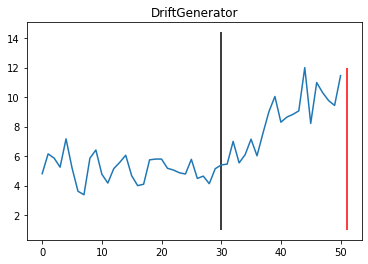

NameError: ignored

In [ ]:
detector = ThreshDetector(0.2, 10)
gen = DriftGenerator(stats.norm, {'loc': 5, 'scale':1}, stats.norm, {'loc': 15, 'scale': 4}, 30, 35)
simulator = Simulator([gen], detector, 1200)

simulator.run(plot = True)

WindowedMonteCarloDetector:

Take two windows of different lengths one of them longer than the other one and we're going to Monte Carlo sample them some amount of times. We'll see if zero exists on that interval and if it does we can say confidently that it's possible the two are the same but if zero is outside the 95 percent highest density interval we're going to say that that's different enough for us to say that these two distributions might be different and will trigger a change.

In [ ]:
class WindowedMonteCarloDetector(ChangeDetector):

    def __init__(self, len1, len2, samples=1000, confidence=0.95, min_samples=50):
        self._window1 = deque(maxlen=len1)
        self._window2 = deque(maxlen=len2)
        self._confidence = confidence
        self._min_samples = min_samples
        self._samples = samples

        self._N = 0
        self._triggered = False
        self.changepoint = 0


    def step(self, datum):
        self._window1.append(datum)
        self._window2.append(datum)
        self._N += 1

        if self._N >= self._min_samples:
            diffs = np.zeros(self._samples)
            for i in xrange(self._samples):
                diffs[i] = random.choice(self._window1) - random.choice(self._window2)

            hdi_min, hdi_max = hdi(diffs, self._confidence)
            self._triggered = not between(0.0, hdi_min, hdi_max)
            if self._triggered:
                self.changepoint = self._N

        return self._triggered


generator = DataBackedGenerator(vec, changepoint)
detector = WindowedMonteCarloDetector(100, 10, 1000, 0.25)
simulator = Simulator([generator], detector)
simulator.run(plot=True)

NameError: ignored

In [ ]:
detector = WindowedMonteCarloDetector(100, 25, confidence=0.95)
simulator = Simulator(generators, detector, 1200)

simulator.run(plot=True)

NameError: ignored

Linearly Penalized Segmentation (PELT) Implementation

In [ ]:
pip install ruptures


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 998 kB 7.1 MB/s 


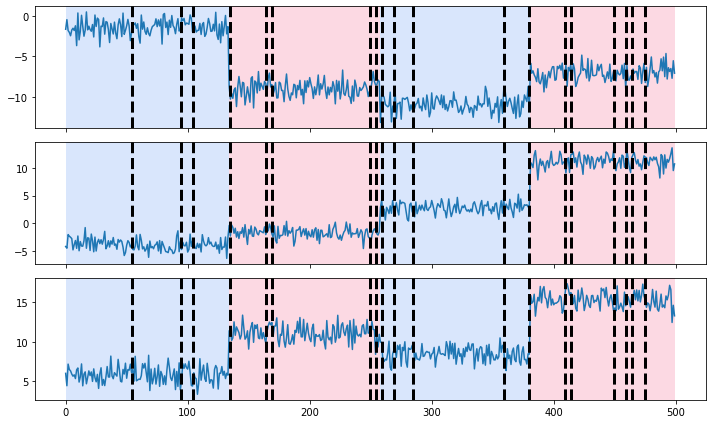

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt #this line of code is creating an error for me

# creation of data
n, dim = 500, 3
n_bkps, sigma = 3, 1
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(signal)
my_bkps = algo.predict(pen=3)

# show results
fig, ax_arr = rpt.display(signal, bkps, my_bkps, figsize=(10, 6))
plt.show()